# Scratch Notebook for Coordinate Systems

In [1]:
# %% Import JAX and enable 64-bit precision
import jax
jax.config.update("jax_enable_x64", True)

In [2]:
# %% Import other libraries
import equinox as eqx
import interpax
import diffrax
import optimistix as optx
import optax

import jax.numpy as jnp
import jax.tree_util as jtu
from dataclasses import dataclass
from functools import partial
import numpy as np
from collections import namedtuple
from typing import NamedTuple
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyvista as pv

from netCDF4 import Dataset

from jaxtyping import ArrayLike, Real

In [10]:
# %% Load my own libraries
%load_ext autoreload
%autoreload 2
from c1lgkt.jax.fields.equilibrium import Equilibrium
from c1lgkt.jax.fields.clebsch import ClebschField
from c1lgkt.jax.fields.geometry_handlers import GeometryHandler, FieldlinePusher
import c1lgkt.jax.particles.particle_motion as particle_motion

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# %% Test loading equilibrium
%matplotlib inline
eq = Equilibrium.from_eqdfile('./tests/D3D141451.eqd')

In [11]:
clebsch = ClebschField(eq)

NameError: name 'rzx1' is not defined

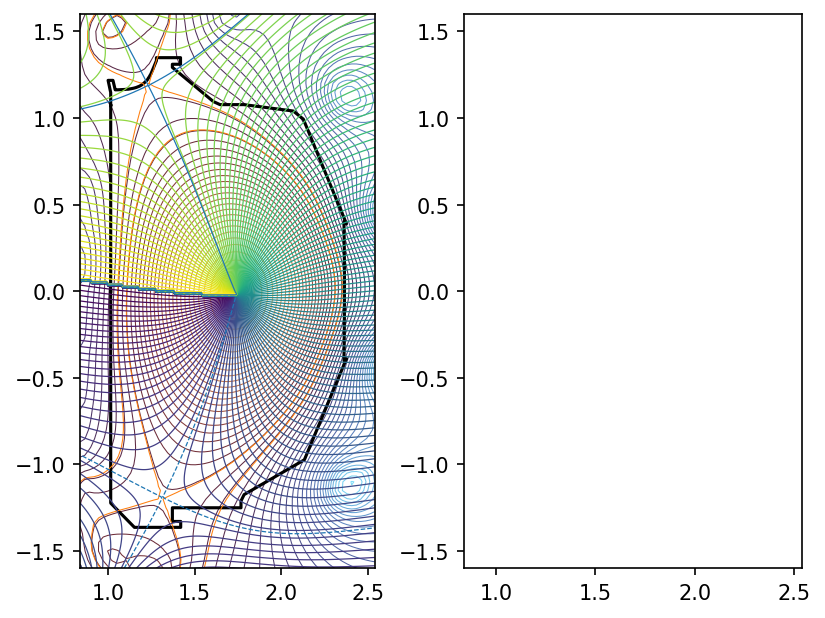

In [14]:
# %% Plot equilibrium
%matplotlib inline
plt.figure(dpi=150)
ax = plt.subplot(121)
ax2 = plt.subplot(122, sharex=ax, sharey=ax)

ax.contour(eq.rgrid, eq.zgrid, eq.psirz, levels=64, cmap='managua', linewidths=0.5)
ax.plot(eq.wallrz[0,:], eq.wallrz[1,:], c='k')
ax.contour(eq.rgrid, eq.zgrid, eq.psirz, levels=[clebsch.x1.psi, clebsch.x2.psi], colors='tab:orange', linewidths=0.5)
ax.set_aspect('equal')

rgrid = np.linspace(eq.rmin, eq.rmax, 256)
zgrid = np.linspace(eq.zmin, eq.zmax, 256)
rplot, zplot = np.meshgrid(rgrid, zgrid, indexing='ij')

psi_ev, ff_ev = eq.compute_psi_and_ff(jnp.ravel(rplot), jnp.ravel(zplot))
(psi, psidr, psidz, psidrr, psidrz, psidzz) = psi_ev

#uv_y = jnp.array([sol.value[0], sol.value[1], sol.value[2], sol.value[3], 0.2, 0.0, 0.2, 0.0])
u, v = clebsch.compute_uv_(rplot.ravel(), zplot.ravel(), clebsch.uv_params)
theta = jnp.arctan2(v, u)

ax.contour(rgrid, zgrid, theta.reshape(rplot.shape).T, levels=np.linspace(-np.pi,np.pi,129), linewidths=0.6)


ux1, vx1 = clebsch.compute_uv_(clebsch.x1.rz[0], clebsch.x1.rz[1], clebsch.uv_params)
uvx1 = ux1 + 1j*vx1
ux2, vx2 = clebsch.compute_uv_(clebsch.x2.rz[0], clebsch.x2.rz[1], clebsch.uv_params)
uvx2 = ux2 + 1j*vx2

ax.contour(rgrid, zgrid, theta.reshape(rplot.shape).T, levels=np.sort([jnp.angle(uvx1), jnp.angle(uvx2)]), linewidths=0.6, colors='tab:blue')

region = jnp.zeros_like(rplot.ravel())


ur = u.ravel()
vr = v.ravel()
zr = zplot.ravel()
rr = rplot.ravel()

closed = (psi >= clebsch.x1.psi*0.05) & (psi < clebsch.x1.psi*0.95) & (zplot.ravel() >= rzx1[1]) & (zplot.ravel() <= rzx2[1])
#outboard = ((zplot.ravel() < 0) & (rplot.ravel() >= rzx1[0]) & (ur * vx1 - vr * ux1 < 0)) | ((zplot.ravel() >= 0) & (rplot.ravel() >= rzx2[0]) & (ur * vx2 - vr * ux2 >= 0))
#inboard = ((zplot.ravel() < 0) & (zplot.ravel() >= rzx1[1]) & (ur * vx1 - vr * ux1 >= 0)) | ((zplot.ravel() >= 0) & (zplot.ravel() < rzx2[1]) & (ur * vx2 - vr * ux2 < 0))

outboard = (psi >= clebsch.x1.psi*0.95) & (psi < clebsch.x2.psi*1.05) & (
    ((zr < 0) & (((zr >= rzx1[1]) & (psi < clebsch.x1.psi)) | ((rr >= rzx1[0]) & (psi >= clebsch.x1.psi)))) |
    ((zr >= 0) & (((zr <= rzx2[1]) & (psi < clebsch.x2.psi)) | ((rr >= rzx2[0]) & (psi >= clebsch.x2.psi))))
)

region = jnp.where(closed, region+1, region)
region = jnp.where(outboard, region+2, region)
#region = jnp.where((psi >= psix1*0.95) & inboard & (psi < psix2*1.05), 3, region)

region = region.reshape(rplot.shape)

ax2.pcolormesh(rgrid, zgrid, region.T, shading='auto', cmap='tab10', vmin=-0.5, vmax=9.5)
ax2.contour(eq.rgrid, eq.zgrid, eq.psirz, levels=64, cmap='managua', linewidths=0.5, alpha=0.5)

ax2.scatter(clebsch.axis.rz[0], clebsch.axis.rz[1], c='k', marker='o')
ax2.scatter(clebsch.x1.rz[0], clebsch.x1.rz[1], c='k', marker='x')
ax2.scatter(clebsch.x2.rz[0], clebsch.x2.rz[1], c='k', marker='x')


## Logarithmic component of the singular part of alpha
def alpha_log(psi, theta):
    # Compute local coordinates at x-points
    p1 = (psi - clebsch.x1.psi) * inertia1
    t1 = (theta - jnp.angle(uvx1)) # NOTE: assumes branch cut where theta \in [-\pi, \pi)

    p2 = (psi - clebsch.x2.psi) * inertia2
    t2 = (theta - jnp.angle(uvx2)) # NOTE: assumes branch cut where theta \in [-\pi, \pi)

    xt1 = 0.5 * (jnp.sqrt(p1**2 + t1**2) + t1)
    yt1 = 0.5 * (jnp.sqrt(p1**2 + (t1-2*jnp.pi)**2) - (t1-2*jnp.pi))

    xt2 = 0.5 * (jnp.sqrt(p2**2 + t2**2) - t2)
    yt2 = 0.5 * (jnp.sqrt(p2**2 + (t2+2*jnp.pi)**2) + (t2+2*jnp.pi))

    return jnp.log(xt1) - jnp.log(xt2) - (jnp.log(yt1) - jnp.log(yt2))

alpha_test = alpha_log(psi, theta)
alpha_test_2 = alpha_log(psi, theta - 2*jnp.pi) + alpha_log(psi, theta) + alpha_log(psi, theta + 2*jnp.pi)

#ax2.contour(rgrid, zgrid, alpha_test.reshape(rplot.shape).T, levels=64, linewidths=0.5, cmap='managua')
cs = ax2.contour(rgrid, zgrid, alpha_test_2.reshape(rplot.shape).T, levels=64, linewidths=0.5, cmap='managua')
#plt.colorbar(cs)
#ax2.contour(rgrid, zgrid, , levels=64, linewidths=0.5, cmap='viridis')


<Figure size 640x480 with 0 Axes>

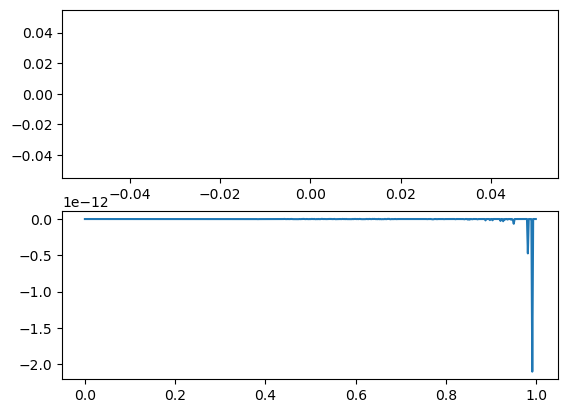

In [90]:
# %% Test the divergence of the q profile?

plt.figure()

psiplot = jnp.linspace(0, 0.999*psix1, 512)
dalpha = alpha_log(psiplot, jnp.pi) - alpha_log(psiplot, -jnp.pi)

thetaplot = jnp.linspace(jnp.angle(uvx1)-4*jnp.pi, jnp.angle(uvx1)+4*jnp.pi, 2048)
alpha_check = alpha_log(psix1, thetaplot)

plt.figure()
plt.subplot(211)
plt.plot(thetaplot/jnp.pi, alpha_check)

plt.subplot(212)
plt.plot(psiplot/psix1, dalpha)

In [71]:
jnp.log(alpha_check[0])

Array([-17.49628202, -17.4750046 , -17.45326464, -17.43104151,
       -17.40831324, -17.38505638, -17.36124572, -17.33685426,
       -17.31185297, -17.28621054, -17.25989323, -17.23286456,
       -17.20508499, -17.17651163, -17.14709774, -17.1167924 ,
       -17.08553986, -17.05327899, -17.01994256, -16.98545638,
       -16.94973831, -16.91269703, -16.87423075, -16.83422542,
       -16.79255272, -16.74906761, -16.70360524, -16.65597719,
       -16.60596677, -16.55332304, -16.49775319, -16.43891269,
       -16.37639234, -16.30970097, -16.23824201, -16.16128097,
       -16.07789936, -15.98692759, -15.88684414, -15.77561852,
       -15.6504554 , -15.50735458, -15.34030054, -15.13962992,
       -14.88831563, -14.55184375, -14.04101941, -12.94242322,
        -2.02283454,  -0.92423834,  -0.41341401,  -0.07694213,
         0.17437216,   0.37504278,   0.54209682,   0.68519764,
         0.81036076,   0.92158638,   1.02166983,   1.11264161,
         1.19602321,   1.27298425,   1.34444321,   1.41

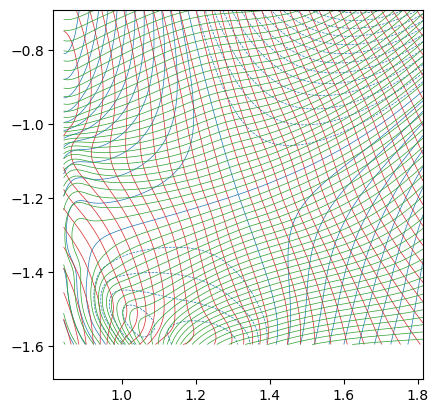

In [12]:
# %% Close up of coordinates near x-point

rgrid = jnp.linspace(rzx1[0]-0.5, rzx1[0]+0.5, 256)
zgrid = jnp.linspace(rzx1[1]-0.5, rzx1[1]+0.5, 256)

rplot, zplot = jnp.meshgrid(rgrid, zgrid, indexing='ij')

psi_ev, ff_ev = eq.compute_psi_and_ff(jnp.ravel(rplot), jnp.ravel(zplot))
(psi, psidr, psidz, psidrr, psidrz, psidzz) = psi_ev

plt.figure()


u, v = fn_uv(rplot, zplot, uv_y)

test = u + 1j*v


ux1, vx1 = fn_uv(rzx1[0], rzx1[1], uv_y)
uvx1 = ux1 + 1j*vx1
ux2, vx2 = fn_uv(rzx2[0], rzx2[1], uv_y)
uvx2 = ux2 + 1j*vx2

ztest = 1j*(psi - psix1)  + (jnp.angle(test.ravel()) - jnp.angle(uvx1)) / (-inertia1)
ztest2 = jnp.sqrt(ztest)

ztest3 = 1j*(psi - psix1)  + (jnp.angle(test.ravel()) - jnp.angle(uvx1)) / inertia1
ztest4 = jnp.sqrt(ztest3)

ax = plt.subplot(111)
ax.contour(rgrid, zgrid, psi.reshape(rplot.shape).T - psix1, levels=32, colors='tab:blue', linewidths=0.5)
#ax.contour(rgrid, zgrid, jnp.angle(test).reshape(rplot.shape).T - jnp.angle(uvx1), levels=32, colors='tab:orange', linewidths=0.6)

ax.contour(rgrid, zgrid, jnp.real(ztest2).reshape(rplot.shape).T, levels=32, linewidths=0.5, colors='tab:red')
ax.contour(rgrid, zgrid, jnp.real(ztest4).reshape(rplot.shape).T, levels=32, linewidths=0.5, colors='tab:green')
ax.set_aspect('equal')


In [13]:
jnp.sqrt(1j)

Array(0.70710678+0.70710678j, dtype=complex128, weak_type=True)

In [122]:
# %% Push some field lines

def fn_fieldline(t, y, args):
    r, varphi, z, alpha = y
    bv = eq.compute_bv(r, z)

    dtheta = grad_theta(r, z, uv_y)
    psidr = eq.interp_psi(r, z, dx=1)
    psidz = eq.interp_psi(r, z, dy=1)

    jacobian = (psidr * dtheta[1] - psidz * dtheta[0])
    dalpha = bv[1,...] / jacobian

    return (bv[0,...], bv[1,...]/r, bv[2,...], dalpha)

term = diffrax.ODETerm(jax.vmap(fn_fieldline, in_axes=(None, 0, None)))
solver = diffrax.Dopri5()
saveat = diffrax.SaveAt(t0=True, t1=True, steps=True)
args = jnp.array([1.0])
stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)

r0 = jnp.max(eq.lcfsrz[0,:]) + jnp.linspace(-0.2, 0.03, 256*256)

sols_fwd = [None] * len(r0)
sols_bak = [None] * len(r0)

y0 = (r0, jnp.zeros_like(r0), jnp.zeros_like(r0), jnp.zeros_like(r0))


sol_fwd = diffrax.diffeqsolve(term, solver, t0=0, t1=16.0, dt0=5e-4, y0=y0,
                            args=args,
                            saveat=saveat,
                            stepsize_controller=stepsize_controller,
                            max_steps=256)
sol_bak = diffrax.diffeqsolve(term, solver, t0=0, t1=-8.0, dt0=-5e-4, y0=y0,
                            args=args,
                            saveat=saveat,
                            stepsize_controller=stepsize_controller,
                            max_steps=256)

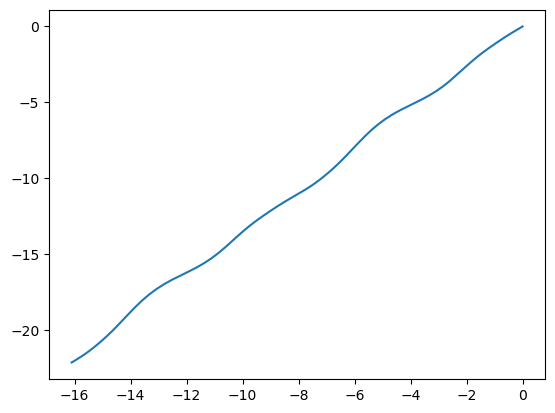

In [123]:
r, varphi, z, alpha = sol_fwd.ys

plt.figure()
plt.plot(varphi[:,0], alpha[:,0], c='tab:blue')

Array([[2.1121891 , 2.11583989, 2.11949069, ..., 2.33488751, 2.33853831,
        2.3421891 ],
       [2.11218958, 2.11584046, 2.11949134, ..., 2.33489241, 2.33854326,
        2.34219412],
       [2.11219104, 2.11584279, 2.11949453, ..., 2.33493885, 2.3385903 ,
        2.34224175],
       ...,
       [       inf,        inf,        inf, ...,        inf,        inf,
               inf],
       [       inf,        inf,        inf, ...,        inf,        inf,
               inf],
       [       inf,        inf,        inf, ...,        inf,        inf,
               inf]], dtype=float64)

In [103]:
fn_fieldline(0, y0, None)[3]

Array([[-0.66935641,        -inf,        -inf, ...,        -inf,
               -inf,        -inf],
       [       -inf, -0.66962558,        -inf, ...,        -inf,
               -inf,        -inf],
       [       -inf,        -inf, -0.66993906, ...,        -inf,
               -inf,        -inf],
       ...,
       [       -inf,        -inf,        -inf, ..., -0.79305843,
               -inf,        -inf],
       [       -inf,        -inf,        -inf, ...,        -inf,
        -0.79776419,        -inf],
       [       -inf,        -inf,        -inf, ...,        -inf,
               -inf, -0.8024587 ]], dtype=float64)

In [ ]:
# %% Gather the solutions into structured arrays

r_grid = jnp.empty((len(r0), sols_fwd[0].ys[0].shape[0] + sols_bak[0].ys[0].shape[0] - 1))
z_grid = jnp.empty((len(r0), sols_fwd[0].ys[0].shape[0] + sols_bak[0].ys[0].shape[0] - 1))
phi_grid = jnp.empty((len(r0), sols_fwd[0].ys[0].shape[0] + sols_bak[0].ys[0].shape[0] - 1))
alpha_grid = jnp.empty((len(r0), sols_fwd[0].ys[0].shape[0] + sols_bak[0].ys[0].shape[0] - 1))

for k in range(len(r0)):
    r_grid = r_grid.at[k,:].set(jnp.concatenate([sols_bak[k].ys[0][::-1], sols_fwd[k].ys[0][1:]]))
    z_grid = z_grid.at[k,:].set(jnp.concatenate([sols_bak[k].ys[2][::-1], sols_fwd[k].ys[2][1:]]))
    phi_grid = phi_grid.at[k,:].set(jnp.concatenate([sols_bak[k].ys[1][::-1], sols_fwd[k].ys[1][1:]]))
    alpha_grid = alpha_grid.at[k,:].set(jnp.concatenate([sols_bak[k].ys[3][::-1], sols_fwd[k].ys[3][1:]]))

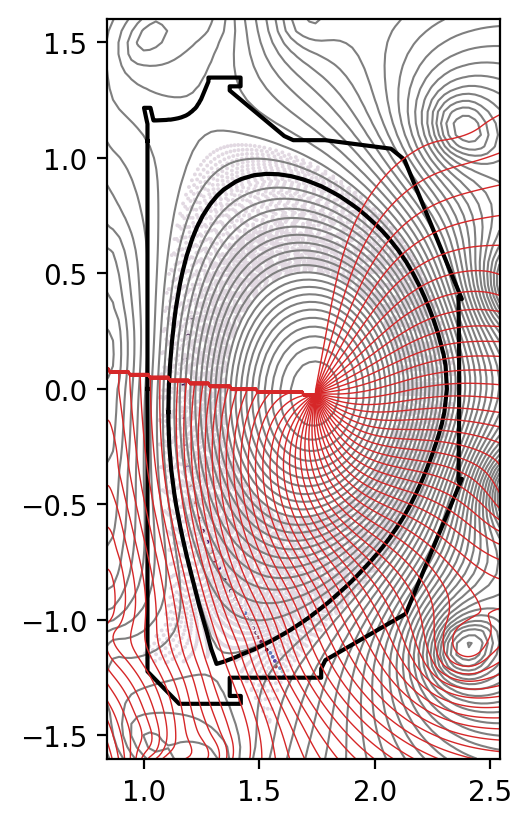

In [ ]:
colors = mpl.cm.viridis(jnp.linspace(0,1,len(r0)))

plt.figure(dpi=200)
ax = plt.subplot(111)
eq.plot_magnetic_geometry(ax)

for k in range(len(r0)):
    ax.scatter(r_grid[k,:],z_grid[k,:], c=alpha_grid[k,:], vmin=20*jnp.pi, vmax=24*jnp.pi, cmap='twilight', s=(100.0/72.0)**2, lw=0)

ax.contour(rgrid, zgrid, xtest.reshape(rplot.shape).T, levels=jnp.linspace(0, 1), linewidths=0.5, colors='tab:red')

In [ ]:
# %%
"""
%matplotlib inline
plt.figure()
ax = plt.subplot(111)

for k in range(len(r0)):
    r_plot = r_grid[k,jnp.isfinite(r_grid[k,:])]
    z_plot = z_grid[k,jnp.isfinite(r_grid[k,:])]

    u_plot, v_plot = fn_uv(r_plot, z_plot, sol.value)
    theta_plot = jnp.arctan2(v_plot, u_plot)

    psi_plot = eq.interp_psi(r_plot, z_plot)

    alpha_plot = alpha_grid[k,jnp.isfinite(r_grid[k,:])]

    jumps = jnp.where(jnp.abs(jnp.diff(theta_plot)) > jnp.pi)[0]
    theta_segments = np.split(theta_plot, jumps + 1)
    alpha_segments = np.split(alpha_plot, jumps + 1)
    for theta_plot, alpha_plot in zip(theta_segments, alpha_segments):
        ax.plot(theta_plot / jnp.pi, np.tanh(alpha_plot/1000), color=colors[k])
"""


'\n%matplotlib inline\nplt.figure()\nax = plt.subplot(111)\n\nfor k in range(len(r0)):\n    r_plot = r_grid[k,jnp.isfinite(r_grid[k,:])]\n    z_plot = z_grid[k,jnp.isfinite(r_grid[k,:])]\n\n    u_plot, v_plot = fn_uv(r_plot, z_plot, sol.value)\n    theta_plot = jnp.arctan2(v_plot, u_plot)\n\n    psi_plot = eq.interp_psi(r_plot, z_plot)\n\n    alpha_plot = alpha_grid[k,jnp.isfinite(r_grid[k,:])]\n\n    jumps = jnp.where(jnp.abs(jnp.diff(theta_plot)) > jnp.pi)[0]\n    theta_segments = np.split(theta_plot, jumps + 1)\n    alpha_segments = np.split(alpha_plot, jumps + 1)\n    for theta_plot, alpha_plot in zip(theta_segments, alpha_segments):\n        ax.plot(theta_plot / jnp.pi, np.tanh(alpha_plot/1000), color=colors[k])\n'